In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split

# Read in data
train = pd.read_csv('./train.csv')
train = train.set_index('PassengerId')
test = pd.read_csv('./test.csv')
test = test.set_index('PassengerId')

avg_male = train['Age'][train['Sex'] == 'male'].mean()
avg_female = train['Age'][train['Sex'] == 'female'].mean()

train['Age'][(train['Age'].isnull()) & (train['Sex'] == 'male')] = avg_male
train['Age'][(train['Age'].isnull()) & (train['Sex'] == 'female')] = avg_female

# # Get rid of null values
train = train[train['Age'].notnull()]
train = train.drop(['Cabin'], axis = 1)

def assign_port(port_code):
    """
    Add port names in place of ports.
    These port names will become column headers once the variable
    is converted to dummies
    """
    if port_code == 'S':
        return 'Southampton'
    elif port_code == 'C':
        return 'Cherbourg'
    elif port_code == 'Q':
        return 'Queenstown'
    else:
        return np.nan

# apply the function for port names and split to dummy variables 
port_embarked = train['Embarked'].apply(assign_port)
port_embarkation = pd.get_dummies(port_embarked, prefix = 'Embarked', drop_first = True)

# # Grab the first character of the cabin, this indicates deck number
# def assign_deck(cabin_code):
#     return cabin_code[:1]
# deck = train['Cabin'].apply(assign_deck)
# deck = pd.get_dummies(deck, prefix = 'Deck', drop_first = True)

# Apply the class dummy variables
classes = pd.get_dummies(train['Pclass'], prefix = 'class', drop_first = True)

# Sex
sex = pd.get_dummies(train['Sex'], drop_first = True)

# Merge the results of all to get the final dataframe ready for analysis
X = train.drop(['Pclass', 'Embarked', 'Survived', 'Name', 'Sex', 'Ticket'], axis = 1)
X = pd.merge(X, classes, left_index=True, right_index=True)
X = pd.merge(X, port_embarkation, left_index=True, right_index=True)
# X = pd.merge(X, deck, left_index=True, right_index=True)
X = pd.merge(X, sex, left_index=True, right_index=True)

y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

C:\Users\thomas.preston\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
this line is to test branchingI added this line for test purposesA value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\thomas.preston\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [89]:
from sklearn.decomposition import PCA

model = PCA(n_components=2)
model.fit(X_train, y_train)
model.predict(X_test)

0.746502763484
0.712954704275
0.739157613875
0.70540499333
0.682973127501
0.694291341084
0.69449590242
0.694358681151
0.716793088114
0.716795629248
0.72056667302
0.72042945175
0.716793088114
0.716655866845
0.720152468077
0.724203036656
0.724340257925
0.731887427736
0.716862969316


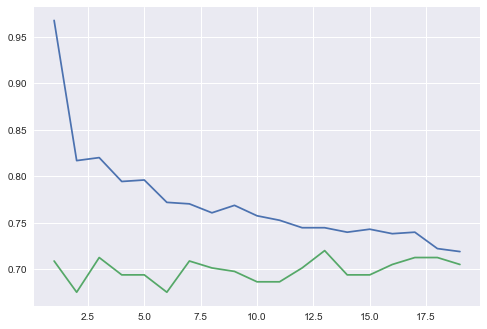

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

knn.score(X_test, y_test)

neighbors = np.arange(1, 20)
train_scores = np.empty(len(neighbors))
test_scores = np.empty(len(neighbors))
# Optimise that knnc
for ind, nbs in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=nbs)
    knn.fit(X_train, y_train)
    train_scores[ind] = knn.score(X_train, y_train)
    test_scores[ind] = knn.score(X_test, y_test)
#     Not sure how cross validation would fit in here...
    print(np.mean(cross_val_score(knn, X_test, y_test, cv=5).mean()))
    
plt.plot(neighbors, train_scores, label = 'training scores')
plt.plot(neighbors, test_scores, label = 'test scores')
plt.title = "Training vs Test Scores"
plt.show()

In [3]:
# Lets fit a Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from sklearn.metrics import confusion_matrix

# Dict of parameters to test with Grid search
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()

tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

tree_cv.fit(X_train, y_train)
y_preds = tree_cv.predict(X_test)

print(confusion_matrix(y_test, y_preds))
print(tree_cv.score(X_test, y_test))

[[139  18]
 [ 33  78]]
0.809701492537


In [4]:
# Give the random forests a try
from sklearn.ensemble import RandomForestClassifier

nests = np.arange(1, 20)
train_acc = np.empty(len(nests))
test_acc = np.empty(len(nests))


for ind, nest in enumerate(nests):
#     model = RandomForestClassifier(n_estimators = nest, criterion = 'entropy')
    model = RandomForestClassifier(n_estimators = nest, criterion = 'gini')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_acc[ind] = model.score(X_train, y_train)
    test_acc[ind] = model.score(X_test, y_test)
    
plt.plot(nests, train_acc)
plt.plot(nests, test_acc)
plt.show()

print('Max accuracy achieved was {0}, with {1} estimators'.format(test_acc.max(), test_acc.argmax() + 1))

ImportError: DLL load failed: The parameter is incorrect.

In [5]:
# Throw some deep learning at the beast 
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

n_input_nodes = X_train.shape[1]

model = Sequential()
model.add(Dense(100, input_shape=(n_input_nodes,), activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['accuracy'])

model.fit(X_train, y_train)

Using TensorFlow backend.


ValueError: Error when checking target: expected dense_3 to have shape (2,) but got array with shape (1,)